In [2]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
!pip install kaggle
import kagglehub
paultimothymooney_chest_xray_pneumonia_path = kagglehub.dataset_download('paultimothymooney/chest-xray-pneumonia')

print('Data source import complete.')


Data source import complete.


# Let's Understand The Problem Itself!

#### Pneumonia is a common respiratory infection, particularly in children, and it requires prompt diagnosis to ensure effective treatment. This project aims to develop a machine learning model that can accurately classify chest X-ray images as either pneumonia or normal.

### **Problem Definition**

*    #### **Objective**: To accurately classify chest X-ray images to identify pneumonia in pediatric patients.
*    #### **Dataset**: 5,863 X-ray images; 2 categories (Pneumonia and Normal).
*    #### **Application**: To enhance efficiency in healthcare and support physicians in their diagnostic processes.


### **Importance**

*    #### Early diagnosis can expedite treatment, positively impacting patient recovery.
*    #### Machine learning can reduce human error by learning from large datasets.



# Importing The Models

In [3]:
# Ignore  the warnings
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

import glob
import numpy as np
import pandas as pd

# For Visuals
import seaborn as sns
import matplotlib.pyplot as plt #for plotting things
from PIL import Image

# Keras Libraries
import keras
from keras.models import Sequential
from keras.layers import Conv2D, Flatten, Dense
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
from tensorflow import keras

# Evaluation Lib.
from sklearn.metrics import classification_report, confusion_matrix

# Class Weights
from sklearn.utils.class_weight import compute_class_weight

# Transfer Learning
from keras.applications.vgg16 import VGG16

In [4]:
import os
print(os.listdir(paultimothymooney_chest_xray_pneumonia_path))

['chest_xray']


# Preparing the Data

In [5]:
import os

# Define the base directory where the dataset is downloaded
# This should be the output of kagglehub.dataset_download()
dataset_base_dir = paultimothymooney_chest_xray_pneumonia_path

# Construct the correct paths using os.path.join
train_dir = os.path.join(dataset_base_dir, 'chest_xray', 'train')
test_dir = os.path.join(dataset_base_dir, 'chest_xray', 'test')
val_dir = os.path.join(dataset_base_dir, 'chest_xray', 'val')

print("\nTrain set:\n" + "-" * 25)
train_num_pneumonia = len(os.listdir(os.path.join(train_dir, 'PNEUMONIA')))
train_num_normal = len(os.listdir(os.path.join(train_dir, 'NORMAL')))
print(f"PNEUMONIA = {train_num_pneumonia}")
print(f"NORMAL = {train_num_normal}")


print("\nTest set:\n" + "-" * 25)
test_num_pneumonia = len(os.listdir(os.path.join(test_dir, 'PNEUMONIA')))
test_num_normal = len(os.listdir(os.path.join(test_dir, 'NORMAL')))
print(f"PNEUMONIA = {test_num_pneumonia}")
print(f"NORMAL = {test_num_normal}")


print("\nValidation set:\n" + "-" * 25)
val_num_pneumonia = len(os.listdir(os.path.join(val_dir, 'PNEUMONIA')))
val_num_normal = len(os.listdir(os.path.join(val_dir, 'NORMAL')))
print(f"PNEUMONIA = {val_num_pneumonia}")
print(f"NORMAL = {val_num_normal}")


Train set:
-------------------------
PNEUMONIA = 3875
NORMAL = 1341

Test set:
-------------------------
PNEUMONIA = 390
NORMAL = 234

Validation set:
-------------------------
PNEUMONIA = 8
NORMAL = 8


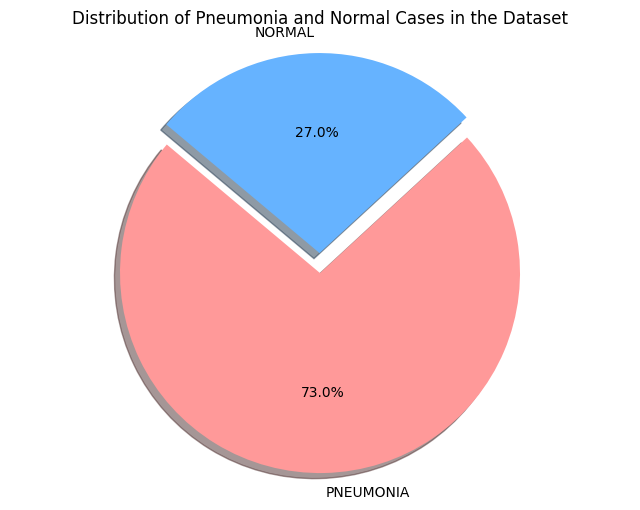

In [6]:
# Total counts
total_pneumonia = train_num_pneumonia + test_num_pneumonia + val_num_pneumonia
total_normal = train_num_normal + test_num_normal + val_num_normal

# Prepare data for pie chart
labels = ['PNEUMONIA', 'NORMAL']
sizes = [total_pneumonia, total_normal]
colors = ['#ff9999', '#66b3ff']
explode = (0.1, 0)  # explode the 1st slice (PNEUMONIA)

# Create pie chart
plt.figure(figsize=(8, 6))
plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', shadow=True, startangle=140)
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

# Title
plt.title('Distribution of Pneumonia and Normal Cases in the Dataset')
plt.show()

In [7]:
data_dir = '/kaggle/input/chest-xray-pneumonia/chest_xray'
paths = glob.glob(data_dir+'/*/*/*.jpeg')
print(f'found {len(paths)} images in the dataset')

found 5856 images in the dataset


In [8]:
data = pd.DataFrame(paths,columns=['path'])
data['label'] = data['path'].apply(lambda x:x.split('/')[6].strip())
data.head()

path      label
0  /kaggle/input/chest-xray-pneumonia/chest_xray/...  PNEUMONIA
1  /kaggle/input/chest-xray-pneumonia/chest_xray/...  PNEUMONIA
2  /kaggle/input/chest-xray-pneumonia/chest_xray/...  PNEUMONIA
3  /kaggle/input/chest-xray-pneumonia/chest_xray/...  PNEUMONIA
4  /kaggle/input/chest-xray-pneumonia/chest_xray/...  PNEUMONIA

In [9]:
counts = data['label'].value_counts()
counts

label
PNEUMONIA    4273
NORMAL       1583
Name: count, dtype: int64

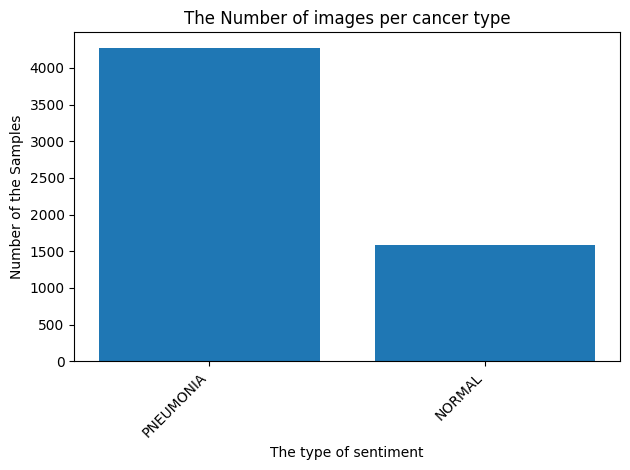

In [10]:
import matplotlib.pyplot as plt

# Assuming 'data' is your DataFrame:
counts = data['label'].value_counts()

plt.bar(counts.index, counts.values, width=0.8)  # Use counts.index for x-axis labels
plt.xlabel('The type of sentiment')
plt.ylabel('Number of the Samples')
plt.title("The Number of images per cancer type")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [11]:
import os
import random
import matplotlib.pyplot as plt

def display_random_images_from_directory(directory, label, num_images=9, cols=3):
    """
    Displays a grid of random chest X-ray images from the specified directory.

    Parameters:
    - directory: str, path to the directory containing the images.
    - label: str, label for the dataset (PNEUMONIA or NORMAL).
    - num_images: int, number of images to display.
    - cols: int, number of columns in the subplot layout.
    """
    # Get list of images
    images = os.listdir(directory)

    # Randomly select images
    selected_images = random.sample(images, min(num_images, len(images)))  # Ensure not to exceed available images

    # Calculate number of rows needed
    rows = (num_images + cols - 1) // cols  # Ceiling division

    # Create figure and axes
    plt.figure(figsize=(20, 5 * rows))

    for i in range(len(selected_images)):
        plt.subplot(rows, cols, i + 1)
        img = plt.imread(os.path.join(directory, selected_images[i]))
        plt.imshow(img, cmap='gray')
        plt.axis('off')
        plt.title(f"{label} - Image {i + 1}")  # Title with the label

    plt.suptitle(f"Random Images from {label} Dataset", fontsize=20)
    plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout to make room for the suptitle
    plt.show()

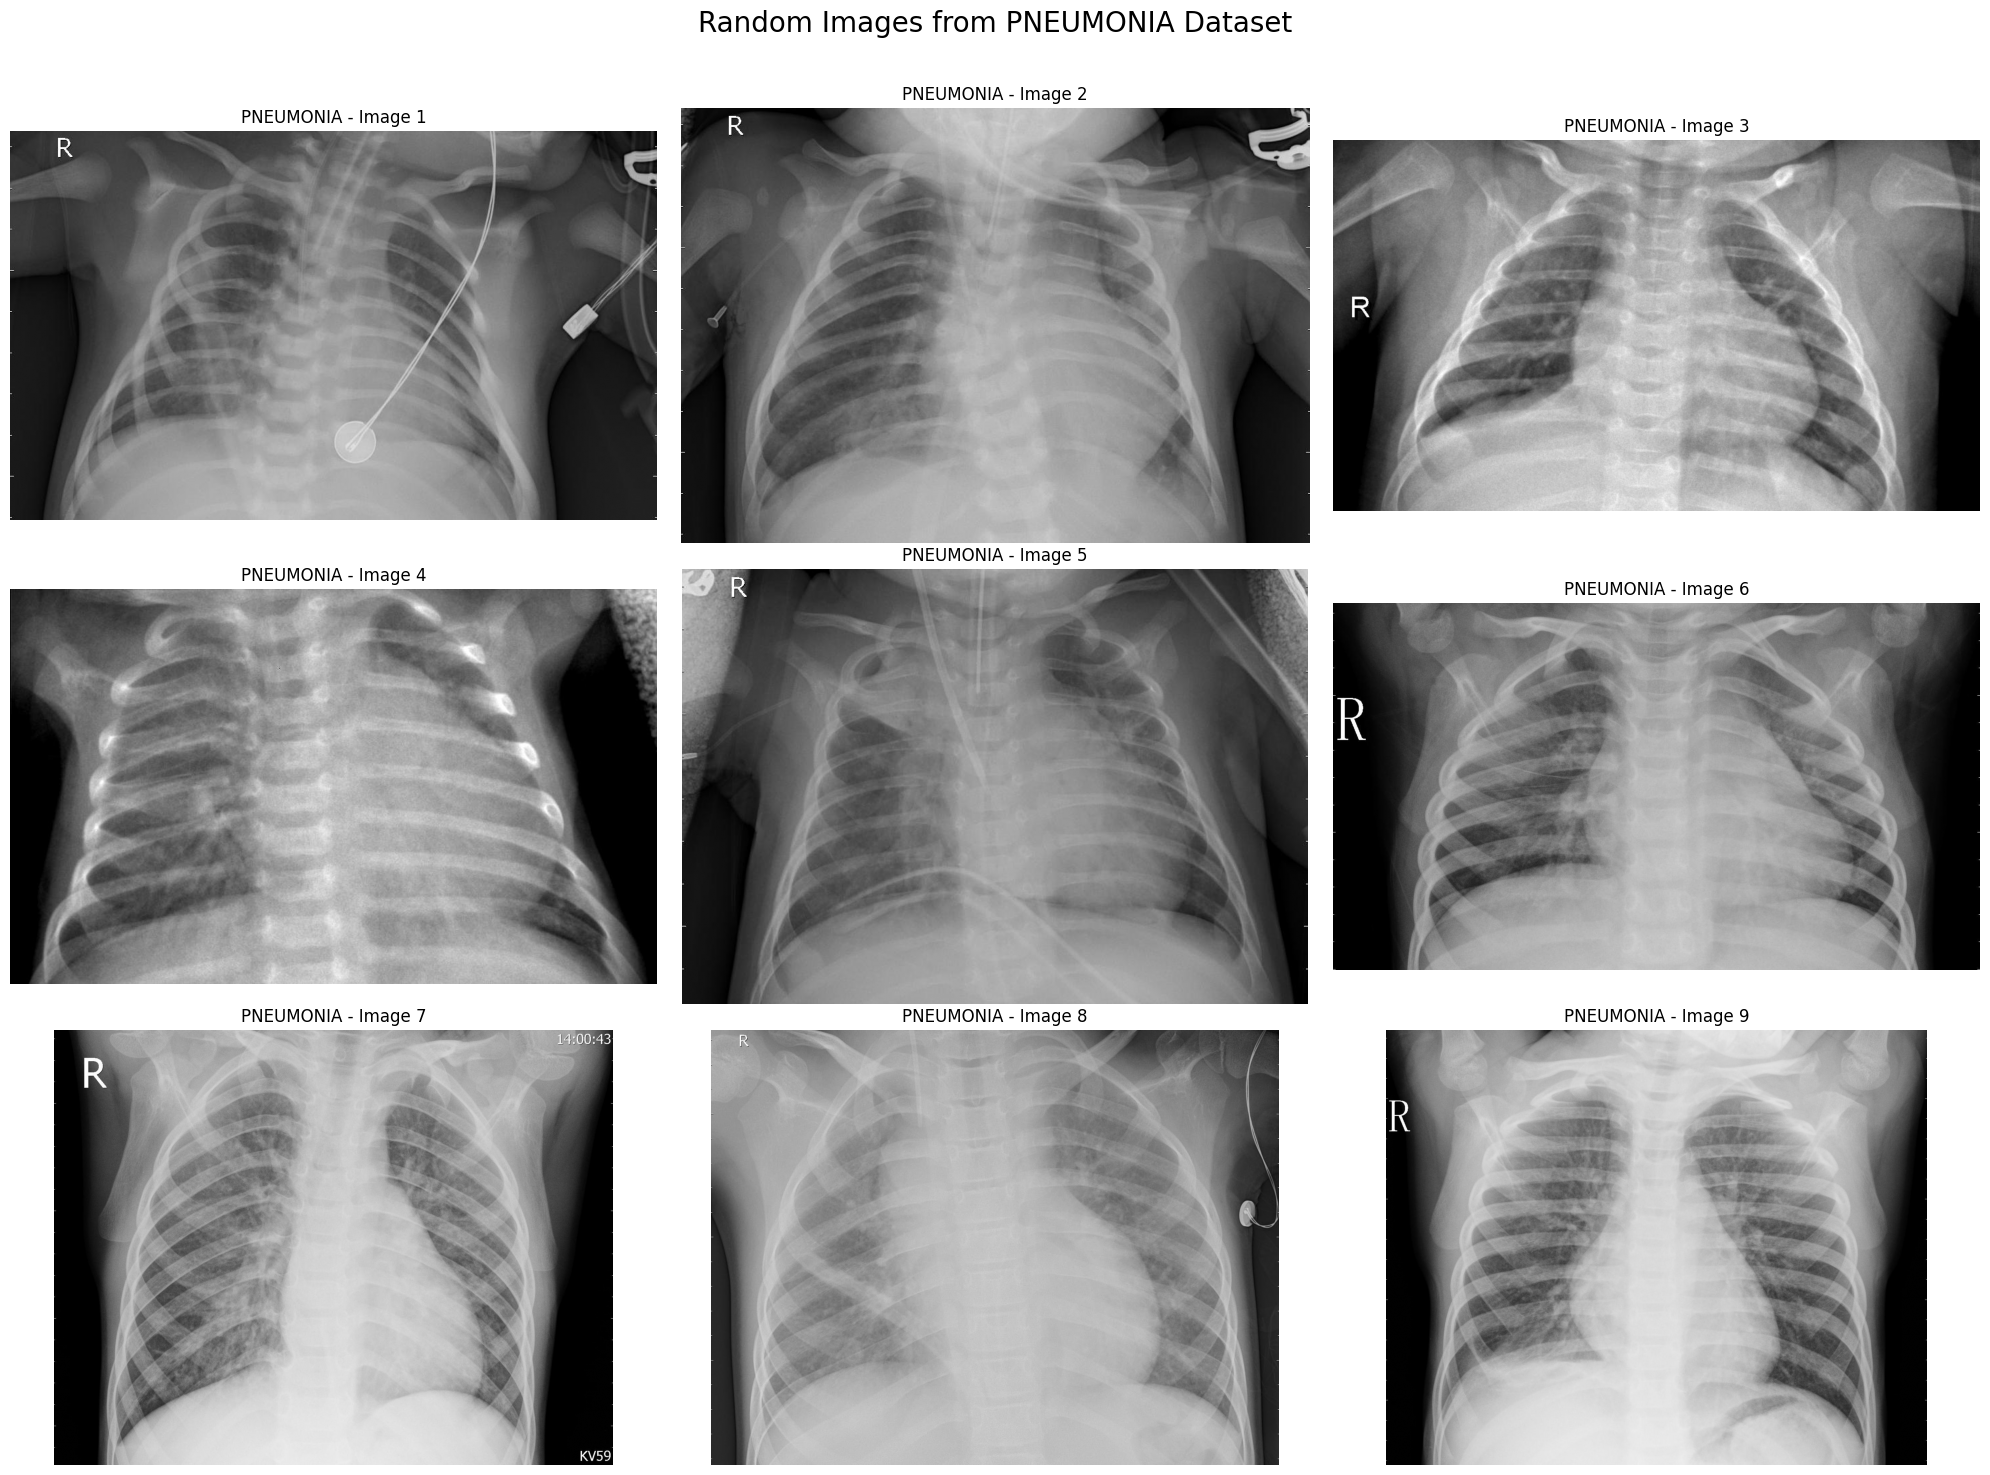

In [12]:
pneumonia_dir = os.path.join(paultimothymooney_chest_xray_pneumonia_path, 'chest_xray', 'train', 'PNEUMONIA') # Update the path to use the correct variable
display_random_images_from_directory(pneumonia_dir, label="PNEUMONIA", num_images=9, cols=3)

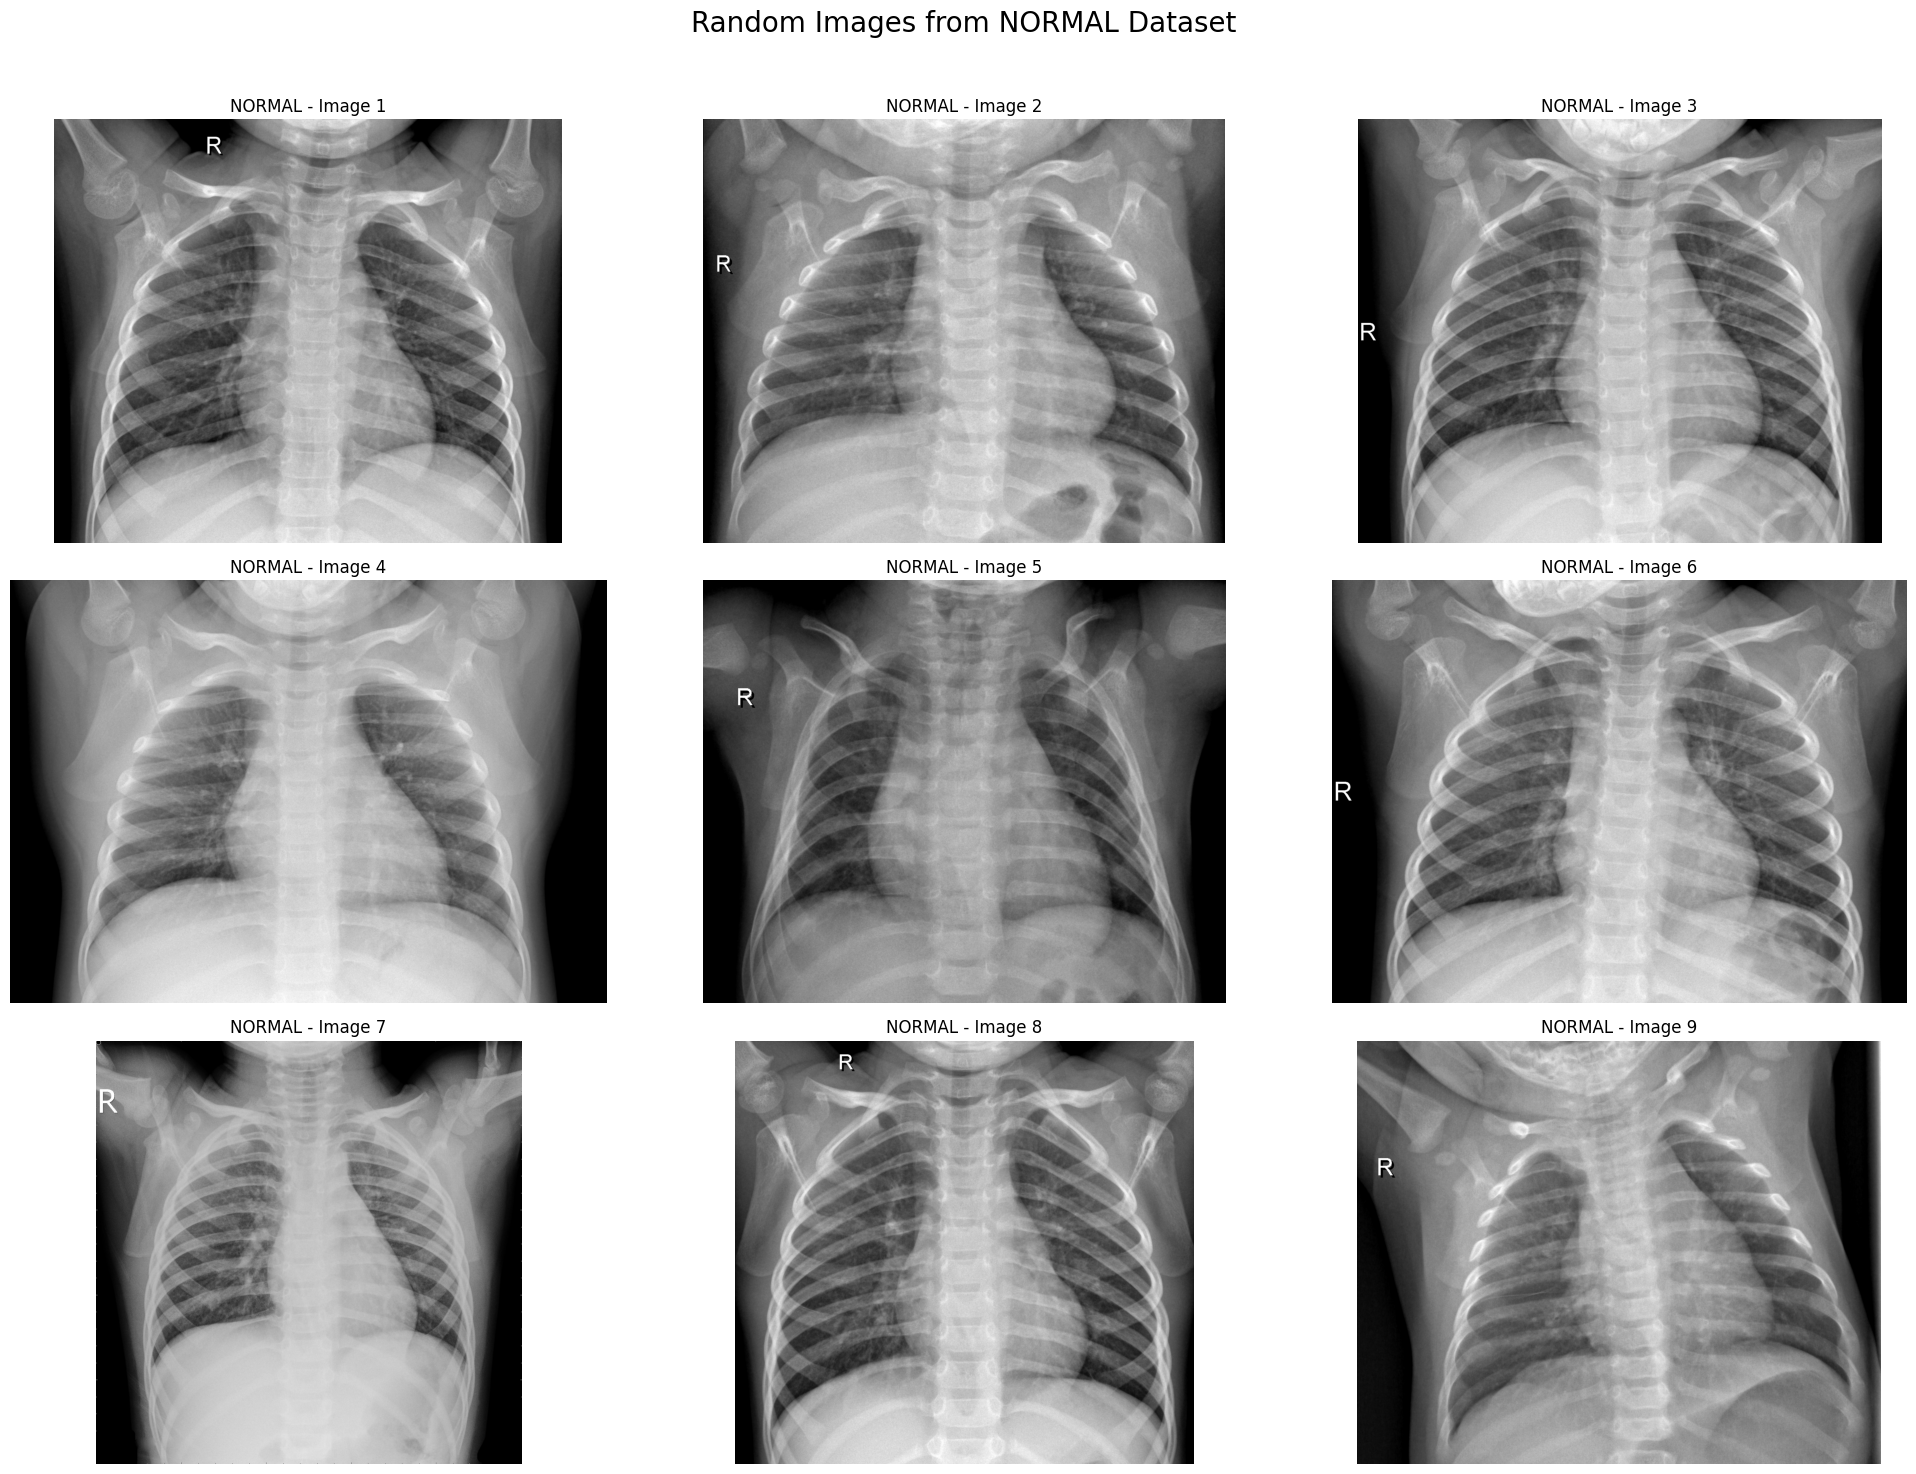

In [13]:
normal_dir = os.path.join(paultimothymooney_chest_xray_pneumonia_path, 'chest_xray', 'train', 'NORMAL') # Use the correct variable to construct the path
display_random_images_from_directory(normal_dir, label="NORMAL", num_images=9, cols=3)

In [14]:
def display_image_and_histogram(image_directory, image_label, color,img_index=0):
    """
    Displays a chest X-ray image and its pixel intensity distribution histogram.

    Parameters:
    - image_directory: str, path to the directory containing the images.
    - image_label: str, label for the dataset (e.g., 'NORMAL' or 'PNEUMONIA').
    - img_index: int, index of the image to display (default is 0 for the first image).
    """
    # Load the specified chest X-ray image
    images = os.listdir(image_directory)
    selected_image = images[img_index]
    sample_img = plt.imread(os.path.join(image_directory, selected_image))

    # Create a figure with 1 row and 2 columns
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))

    # Display the chest X-ray image
    axes[0].imshow(sample_img, cmap='gray')
    axes[0].axis('off')  # Hide axis
    axes[0].set_title(f'Raw Chest X-Ray Image - {image_label}')

    # Display image dimensions and statistics
    print(f"The dimensions of the image are {sample_img.shape[0]} pixels width and {sample_img.shape[1]} pixels height, one single color channel.")
    print(f"The maximum pixel value is {sample_img.max():.4f} and the minimum is {sample_img.min():.4f}")
    print(f"The mean value of the pixels is {sample_img.mean():.4f} and the standard deviation is {sample_img.std():.4f}")

    # Create the histogram of pixel intensities
    sns.histplot(sample_img.ravel(), bins=30, ax=axes[1], kde=False, color=color)
    axes[1].set_title('Distribution of Pixel Intensities in the Image')
    axes[1].set_xlabel('Pixel Intensity')
    axes[1].set_ylabel('# Pixels in Image')
    axes[1].legend([f"Pixel Mean {sample_img.mean():.4f} & Standard Deviation {sample_img.std():.4f}"], loc='upper right')

    # Adjust layout
    plt.tight_layout()
    plt.show()

The dimensions of the image are 712 pixels width and 1024 pixels height, one single color channel.
The maximum pixel value is 255.0000 and the minimum is 0.0000
The mean value of the pixels is 74.9850 and the standard deviation is 40.9280


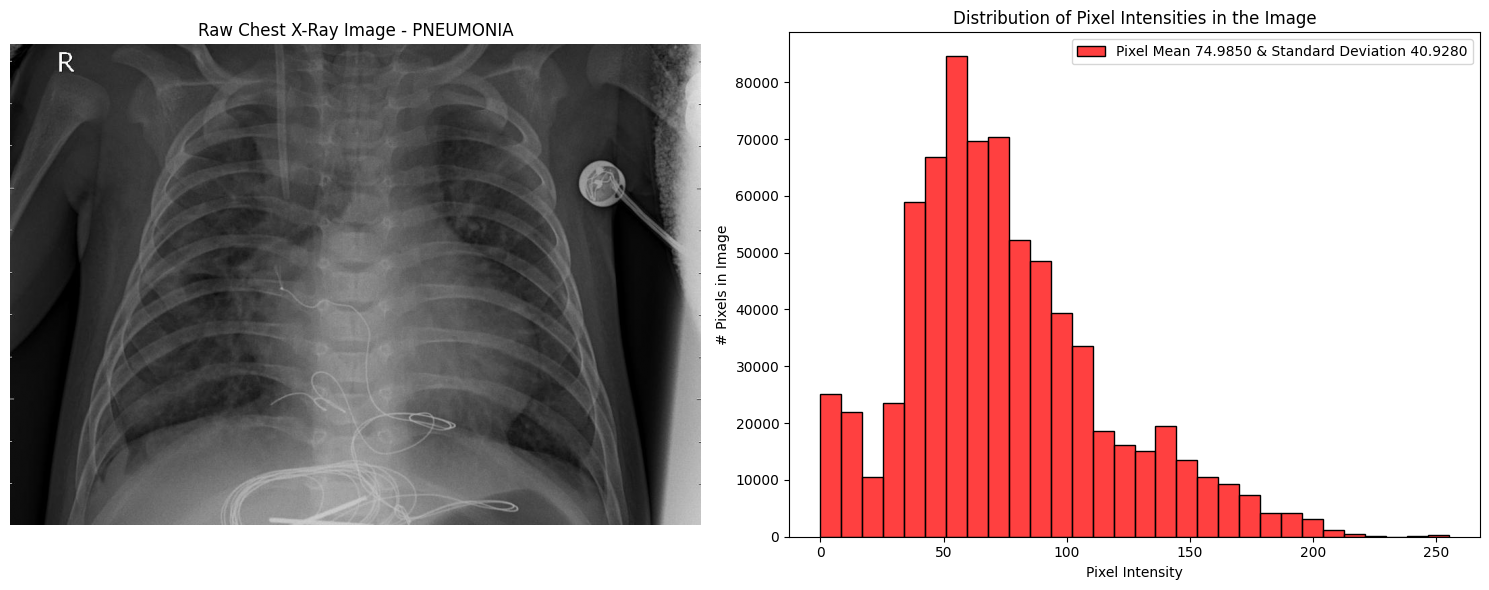

In [15]:
pneumonia_dir = os.path.join(paultimothymooney_chest_xray_pneumonia_path, 'chest_xray', 'train', 'PNEUMONIA') # Use the correct path variable
display_image_and_histogram(pneumonia_dir, image_label="PNEUMONIA", img_index=0, color ="red")

The dimensions of the image are 1128 pixels width and 1336 pixels height, one single color channel.
The maximum pixel value is 255.0000 and the minimum is 0.0000
The mean value of the pixels is 73.2978 and the standard deviation is 38.1653


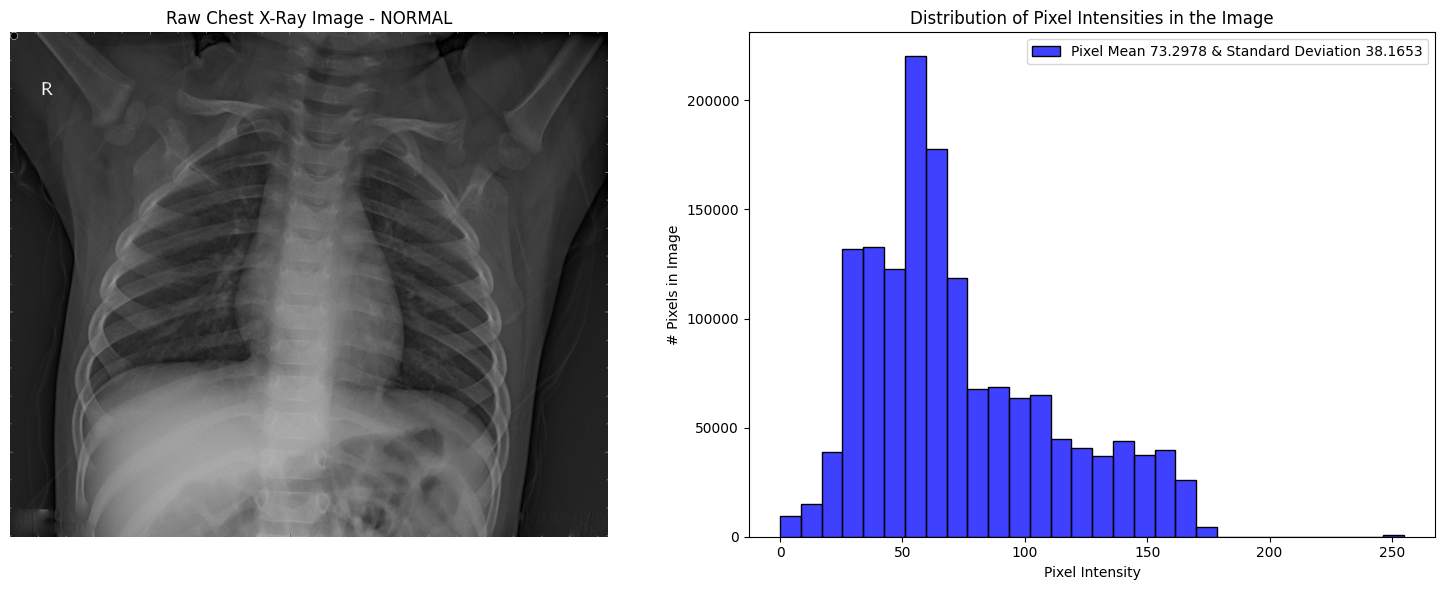

In [16]:
normal_dir = os.path.join(paultimothymooney_chest_xray_pneumonia_path, 'chest_xray', 'train', 'NORMAL') # Use paultimothymooney_chest_xray_pneumonia_path instead of a hardcoded path
display_image_and_histogram(normal_dir, image_label="NORMAL", img_index=0,color="blue")

In [17]:
batch_size = 64
image_size = (150, 150)

## Imbalanced Solution

In [18]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

image_generator = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range = 30,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.2, # Randomly zoom image
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip = True,  # randomly flip images
        vertical_flip=False)  # randomly flip images

In [19]:
training_set = image_generator.flow_from_directory(train_dir,
                                            batch_size=batch_size,
                                            shuffle=True,
                                            class_mode='binary',
                                            target_size=image_size)

validation_set = image_generator.flow_from_directory(val_dir,
                                                batch_size=batch_size,
                                                shuffle=False,
                                                class_mode='binary',
                                                target_size=image_size)

test_set = image_generator.flow_from_directory(test_dir,
                                            batch_size=1,
                                            shuffle=False,
                                            class_mode='binary',
                                            target_size=image_size)

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


## Class Imbalance Problem

### downsample

In [20]:
import os
import pandas as pd

# Define the base directory where the dataset is downloaded
# This should be the output of kagglehub.dataset_download()
dataset_base_dir = paultimothymooney_chest_xray_pneumonia_path

# Construct the correct paths using os.path.join
train_dir = os.path.join(dataset_base_dir, 'chest_xray', 'train')

# Get the lists of all image paths for each class
pneumonia_images = [os.path.join(train_dir, 'PNEUMONIA', img) for img in os.listdir(os.path.join(train_dir, 'PNEUMONIA'))]
normal_images = [os.path.join(train_dir, 'NORMAL', img) for img in os.listdir(os.path.join(train_dir, 'NORMAL'))]

# Create a DataFrame with the paths and labels
data = pd.DataFrame({
    'path': pneumonia_images + normal_images,
    'label': ['PNEUMONIA'] * len(pneumonia_images) + ['NORMAL'] * len(normal_images)
})

# Now you can proceed with the resampling step:
from sklearn.utils import resample

df_majority = data[data.label == 'PNEUMONIA']
df_minority = data[data.label == 'NORMAL']

# Downsample majority class
df_majority_downsampled = resample(df_majority,
                                   replace=False,
                                   n_samples=len(df_minority),
                                   random_state=42)

# Combine minority class with downsampled majority class
downsampled_data = pd.concat([df_minority, df_majority_downsampled])

### downsample with ratio

In [21]:
df_majority = data[data.label == 'PNEUMONIA']
df_minority = data[data.label == 'NORMAL']

majority_count = len(df_majority)  # PNEUMONIA örnek sayısı
minority_count = len(df_minority)  # NORMAL örnek sayısı

# ratio count?
desired_ratio = 2

# new majority (PNEUMONIA) sample count
new_majority_count = minority_count * desired_ratio

# Downsample majority class to desired ratio
df_majority_downsampled = resample(df_majority,
                                   replace=False,
                                   n_samples=new_majority_count,
                                   random_state=42)

# Combine minority class with downsampled majority class
downsampled_data = pd.concat([df_minority, df_majority_downsampled])

# lets look at new sample size
print(downsampled_data['label'].value_counts())

label
PNEUMONIA    2682
NORMAL       1341
Name: count, dtype: int64


In [22]:
counts = downsampled_data['label'].value_counts()
counts

label
PNEUMONIA    2682
NORMAL       1341
Name: count, dtype: int64

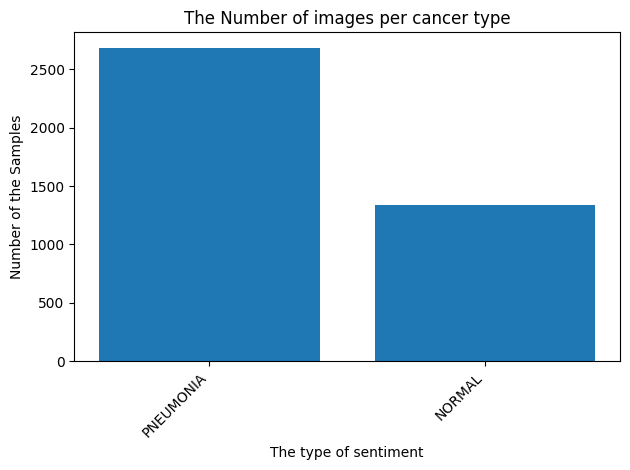

In [23]:
plt.bar(['PNEUMONIA','NORMAL'], counts, width=0.8)
plt.xlabel('The type of sentiment')
plt.ylabel('Number of the Samples')
plt.title("The Number of images per cancer type")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [24]:
downsampled_data['label'] = downsampled_data['label'].apply(lambda x: '1' if x == 'PNEUMONIA' else '0')
downsampled_data.head()

path label
3875  /kaggle/input/chest-xray-pneumonia/chest_xray/...     0
3876  /kaggle/input/chest-xray-pneumonia/chest_xray/...     0
3877  /kaggle/input/chest-xray-pneumonia/chest_xray/...     0
3878  /kaggle/input/chest-xray-pneumonia/chest_xray/...     0
3879  /kaggle/input/chest-xray-pneumonia/chest_xray/...     0

In [25]:
from sklearn.model_selection import train_test_split
# Splitting data
train_df, temp_df = train_test_split(downsampled_data, test_size=0.2, random_state=42)
test_df, valid_df = train_test_split(temp_df, test_size=0.5, random_state=42)
print("Training set shapes:", train_df.shape)
print("Validation set shapes:", valid_df.shape)
print("Testing set shapes:", test_df.shape)

Training set shapes: (3218, 2)
Validation set shapes: (403, 2)
Testing set shapes: (402, 2)


In [26]:
train_datagen = ImageDataGenerator(rescale=1.0/255)
test_datagen = ImageDataGenerator(rescale=1./255)

image_generator = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    samplewise_center=True,
    samplewise_std_normalization=True
)

# IMAGE_SIZE = (256,256)

# Training data generator
training_set = image_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='path',
    y_col='label',
    target_size=(180, 180),
    batch_size=32,
    class_mode='binary',
    color_mode='rgb',
    shuffle=True
)

# Validation data generator
validation_set = image_generator.flow_from_dataframe(
    dataframe=valid_df,
    x_col='path',
    y_col='label',
    target_size=(180, 180),
    batch_size=32,
    color_mode='rgb',
    class_mode='binary',
    shuffle=False
)

# Testing data generator
test_set = image_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='path',
    y_col='label',
    target_size=(180, 180),
    color_mode='rgb',
    batch_size=64,
    class_mode='binary',
    shuffle=False
)

Found 3218 validated image filenames belonging to 2 classes.
Found 403 validated image filenames belonging to 2 classes.
Found 402 validated image filenames belonging to 2 classes.


In [27]:
dict_class = training_set.class_indices
print('Dictionary: {}'.format(dict_class))
class_names = list(dict_class.keys())  # storing class/breed names in a list
print('Class labels: {}'.format(class_names))

Dictionary: {'0': 0, '1': 1}
Class labels: ['0', '1']


In [28]:
# Dataset characteristics
print("Dataset Characteristics of Train Data Set:")
print("Number of images:", len(training_set.classes))
print("Number of NORMAL images:", len([label for label in training_set.classes if label == 0]))
print("Number of PNEUMONIA images:", len([label for label in training_set.classes if label == 1]))
print()

print("Dataset Characteristics of Test Data Set:")
print("Number of images:", len(test_set.classes))
print("Number of NORMAL images:", len([label for label in test_set.classes if label == 0]))
print("Number of PNEUMONIA images:", len([label for label in test_set.classes if label == 1]))
print()

print("Dataset Characteristics of Val Data Set:")
print("Number of images:", len(validation_set.classes))
print("Number of NORMAL images:", len([label for label in validation_set.classes if label == 0]))
print("Number of PNEUMONIA images:", len([label for label in validation_set.classes if label == 1]))
print()

Dataset Characteristics of Train Data Set:
Number of images: 3218
Number of NORMAL images: 1057
Number of PNEUMONIA images: 2161

Dataset Characteristics of Test Data Set:
Number of images: 402
Number of NORMAL images: 143
Number of PNEUMONIA images: 259

Dataset Characteristics of Val Data Set:
Number of images: 403
Number of NORMAL images: 141
Number of PNEUMONIA images: 262



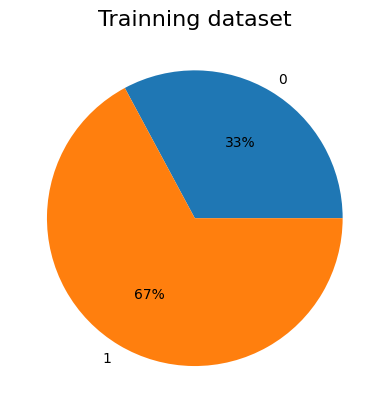

In [29]:
frequency = np.unique(training_set.classes, return_counts=True)

plt.title("Trainning dataset", fontsize='16')
plt.pie(frequency[1], labels = class_names, autopct='%1.0f%%');

## Class weights

In [30]:
# Class weights

weight_for_0 = train_num_pneumonia / (train_num_normal + train_num_pneumonia)
weight_for_1 = train_num_normal / (train_num_normal + train_num_pneumonia)

class_weight = {0: weight_for_0, 1: weight_for_1}

print(f"Weight for class 0: {weight_for_0:.2f}")
print(f"Weight for class 1: {weight_for_1:.2f}")

Weight for class 0: 0.74
Weight for class 1: 0.26


In [31]:
class_weights = compute_class_weight(class_weight = "balanced", classes= np.unique(training_set.classes), y= training_set.classes)
class_weights = dict(zip(np.unique(training_set.classes), class_weights))
class_weights

{np.int64(0): np.float64(1.522232734153264),
 np.int64(1): np.float64(0.7445627024525683)}

# Modelling (Creating CNN Model and Transfer Learning)

In [32]:
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D, Dropout, Flatten, BatchNormalization
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.optimizers import Adam , Adamax

In [33]:
model = Sequential()

model.add(Conv2D(filters=32, kernel_size=(3, 3), input_shape=(150, 150, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Flatten())

model.add(Dense(256, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))


model.add(Dense(1, activation='sigmoid'))

'''model.compile(loss='binary_crossentropy',
              optimizer='sgd',
              metrics=['accuracy'])
'''
model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy',
                           tf.keras.metrics.Precision(),
                           tf.keras.metrics.Recall()])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 148, 148, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 72, 72, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 34, 34, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 36992)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     9,470,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,605,569 (36.64 MB)

 Trainable params: 9,605,121 (36.64 MB)

 Non-trainable params: 448 (1.75 KB)

In [34]:
model = Sequential()
model.add(Conv2D(32 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu' , input_shape = (180,180,3)))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.1))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(128 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(256 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Flatten())
model.add(Dense(units = 128 , activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(units = 1 , activation = 'sigmoid'))
model.compile(optimizer = "rmsprop" , loss = 'binary_crossentropy' , metrics = ['accuracy'])
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 180, 180, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 180, 180, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 90, 90, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 90, 90, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 90, 90, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 90, 90, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 45, 45, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 45, 45, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 45, 45, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 23, 23, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 23, 23, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 23, 23, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 23, 23, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 12, 12, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 12, 12, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 12, 12, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 9216)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │     1,179,776 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴─────────────

 Total params: 1,607,425 (6.13 MB)

 Trainable params: 1,606,337 (6.13 MB)

 Non-trainable params: 1,088 (4.25 KB)

In [35]:
import tensorflow as tf
from tensorflow.keras import layers, models


def create_model(input_shape:tuple) -> tf.keras.Model:

    inputs = layers.Input(shape=input_shape)

    # Convolutional layers
    x = layers.Conv2D(32, (3, 3), padding = 'same', activation="relu")(inputs)
    x = layers.MaxPooling2D(pool_size=(2, 2))(x)

    x = layers.Conv2D(64, (3, 3),padding = 'same', activation="relu")(x)
    x = layers.MaxPooling2D(pool_size=(2, 2))(x)
    # x = layers.BatchNormalization()(x)

    x = layers.Conv2D(32, (3, 3), padding = 'same', activation="relu")(inputs)
    x = layers.MaxPooling2D(pool_size=(2, 2))(x)

    # Flatten for dense layers
    x = layers.Flatten()(x)

    # Dense layers
    x = layers.Dense(32, activation="relu")(x)
    # x = layers.Dropout(0.2)(x)
    outputs = layers.Dense(1, activation="sigmoid")(x)

    # Model creation and compilation
    model = models.Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer="adam", loss="binary_crossentropy",
                   metrics=["accuracy", tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

    return model

img_size = (180, 180)
channels = 3
input_shape = (img_size[0], img_size[1], channels)
class_count = len(list(training_set.class_indices.keys()))

model = create_model(input_shape)
model.summary()

Model: "functional_39"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 180, 180, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 90, 90, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 259200)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 32)             │     8,294,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,295,361 (31.64 MB)

 Trainable params: 8,295,361 (31.64 MB)

 Non-trainable params: 0 (0.00 B)

In [36]:
import tensorflow as tf
from tensorflow.keras import layers, models

def conv_block(filters:int,activation:str='relu') -> tf.keras.Sequential:

    block = tf.keras.Sequential([
        layers.SeparableConv2D(filters, 3, activation=activation, padding='same'),
        layers.SeparableConv2D(filters, 3, activation=activation, padding='same'),
        layers.BatchNormalization(),
        layers.MaxPool2D()
    ])

    return block

def dense_block(units:int, dropout_rate:float,activation:str = 'relu') -> tf.keras.Sequential:

    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation=activation),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate)
    ])

    return block


def build_model(input_shape:tuple) -> tf.keras.Model:

    model = models.Sequential([
        layers.Input(shape=input_shape),

        # İlk convolutional blok
        layers.Conv2D(16, 3, activation='relu', padding='same'),
        layers.Conv2D(16, 3, activation='relu', padding='same'),
        layers.MaxPool2D(),

        # Daha fazla convolutional bloklar
        conv_block(32),
        conv_block(64),
        conv_block(128),
        layers.Dropout(0.2),
        conv_block(256),
        layers.Dropout(0.2),

        # Flatten ve dense bloklar
        layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(256, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),

        # Çıkış katmanı
        layers.Dense(1, activation='sigmoid')
    ])


    # Model derlemesi
    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy',
                           tf.keras.metrics.Precision(),
                           tf.keras.metrics.Recall()])


    return model

In [37]:
img_size = (150, 150)
channels = 3
input_shape = (img_size[0], img_size[1], channels)

model = build_model(input_shape)
model.summary()

Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_11 (Conv2D)              │ (None, 150, 150, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 150, 150, 16)   │         2,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 75, 75, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_2 (Sequential)       │ (None, 37, 37, 32)     │         2,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_3 (Sequential)       │ (None, 18, 18, 64)     │         7,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_4 (Sequential)       │ (None, 9, 9, 128)      │        27,072 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 9, 9, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_5 (Sequential)       │ (None, 4, 4, 256)      │       103,296 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_6 (Sequential)       │ (None, 512)            │     2,099,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_7 (Sequential)       │ (None, 256)            │       132,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_8 (Sequential)       │ (None, 128)            │        33,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_9 (Sequential)       │ (None, 64)             │         8,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,416,737 (9.22 MB)

 Trainable params: 2,413,857 (9.21 MB)

 Non-trainable params: 2,880 (11.25 KB)

In [38]:
from tensorflow.keras.layers import Flatten, Dense, Dropout, Conv2D, MaxPool2D, BatchNormalization
from tensorflow.keras.layers import GlobalAveragePooling2D, LayerNormalization, ReLU, LeakyReLU
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers.schedules import CosineDecay

# Cosine Decay ile Learning Rate Annealing (Başlangıç öğrenme hızı: 0.001)
initial_learning_rate = 0.001
lr_schedule = CosineDecay(initial_learning_rate, decay_steps=10000)
optimizer = tf.keras.optimizers.Adamax(learning_rate=lr_schedule)

model = Sequential()

# İlk Conv2D katmanı
model.add(Conv2D(filters=32, kernel_size=(3, 3), input_shape=(180, 180, 3), kernel_regularizer=l2(0.01)))
model.add(BatchNormalization())
model.add(ReLU())
# model.add(LeakyReLU(alpha=0.1))
model.add(MaxPool2D(pool_size=(2, 2)))

# İkinci Conv2D katmanı
model.add(Conv2D(filters=64, kernel_size=(3, 3), kernel_regularizer=l2(0.01)))
model.add(BatchNormalization())
model.add(ReLU())
model.add(MaxPool2D(pool_size=(2, 2)))

# Üçüncü Conv2D katmanı
model.add(Conv2D(filters=128, kernel_size=(3, 3), kernel_regularizer=l2(0.01)))
model.add(BatchNormalization())
model.add(ReLU())
model.add(MaxPool2D(pool_size=(2, 2)))

# Flatten yerine GlobalAveragePooling2D kullanıldı
model.add(Flatten())

# Layer Normalization eklendi (isteğe bağlı)
#model.add(LayerNormalization())

# Dense katmanlar
model.add(Dense(256, kernel_regularizer=l2(0.01)))
model.add(BatchNormalization())
model.add(ReLU())
# model.add(Dropout(0.3))

model.add(Dense(128, kernel_regularizer=l2(0.01)))
model.add(BatchNormalization())
model.add(ReLU())
# model.add(Dropout(0.3))

model.add(Dense(64, kernel_regularizer=l2(0.01)))
model.add(BatchNormalization())
model.add(ReLU())
# model.add(Dropout(0.2))

model.add(Dense(32, kernel_regularizer=l2(0.01)))
model.add(BatchNormalization())
model.add(ReLU())
# model.add(Dropout(0.2))

# Çıkış katmanı
model.add(Dense(1, activation='sigmoid'))

# Modelin derlenmesi
model.compile(optimizer=optimizer,  # Cosine Decay ile Adamax optimizer
              loss='binary_crossentropy',
              metrics=['accuracy',
                       tf.keras.metrics.Precision(),
                       tf.keras.metrics.Recall()])

# Model özetini göster
model.summary()


Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_13 (Conv2D)              │ (None, 178, 178, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_16          │ (None, 178, 178, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu (ReLU)                    │ (None, 178, 178, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_16 (MaxPooling2D) │ (None, 89, 89, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 87, 87, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_17          │ (None, 87, 87, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_1 (ReLU)                  │ (None, 87, 87, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_17 (MaxPooling2D) │ (None, 43, 43, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 41, 41, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_18          │ (None, 41, 41, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_2 (ReLU)                  │ (None, 41, 41, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_18 (MaxPooling2D) │ (None, 20, 20, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 51200)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 256)            │    13,107,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_19          │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_3 (ReLU)                  │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_20          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_4 (ReLU)                  │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_21          │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_5 (ReLU)                  │ (None, 64)             │             

 Total params: 13,246,785 (50.53 MB)

 Trainable params: 13,245,377 (50.53 MB)

 Non-trainable params: 1,408 (5.50 KB)

In [39]:
from tensorflow.keras.layers import Flatten, Dense, Dropout, Conv2D, MaxPool2D, BatchNormalization
from tensorflow.keras.layers import ReLU, LeakyReLU
from tensorflow.keras.regularizers import l2

model = Sequential()

# İlk Conv2D katmanı
model.add(Conv2D(filters=32, kernel_size=(3, 3), input_shape=(180, 180, 3), kernel_regularizer=l2(0.01)))
model.add(BatchNormalization())
model.add(ReLU())
# model.add(LeakyReLU(alpha=0.1))
model.add(MaxPool2D(pool_size=(2, 2)))

# İkinci Conv2D katmanı
model.add(Conv2D(filters=64, kernel_size=(3, 3), kernel_regularizer=l2(0.01)))
model.add(BatchNormalization())
model.add(ReLU())
model.add(MaxPool2D(pool_size=(2, 2)))

# Üçüncü Conv2D katmanı
model.add(Conv2D(filters=128, kernel_size=(3, 3), kernel_regularizer=l2(0.01)))
model.add(BatchNormalization())
model.add(ReLU())
model.add(MaxPool2D(pool_size=(2, 2)))

# Flatten yerine GlobalAveragePooling2D kullanıldı
model.add(Flatten())

# Layer Normalization eklendi (isteğe bağlı)
#model.add(LayerNormalization())

model.add(Dense(512, kernel_regularizer=l2(0.01)))
model.add(BatchNormalization())
model.add(ReLU())

# Dense katmanlar
model.add(Dense(256, kernel_regularizer=l2(0.01)))
model.add(BatchNormalization())
model.add(ReLU())
# model.add(Dropout(0.3))

model.add(Dense(128, kernel_regularizer=l2(0.01)))
model.add(BatchNormalization())
model.add(ReLU())
# model.add(Dropout(0.3))

model.add(Dense(64, kernel_regularizer=l2(0.01)))
model.add(BatchNormalization())
model.add(ReLU())
# model.add(Dropout(0.2))

model.add(Dense(32, kernel_regularizer=l2(0.01)))
model.add(BatchNormalization())
model.add(ReLU())
# model.add(Dropout(0.2))

# Çıkış katmanı
model.add(Dense(1, activation='sigmoid'))

# Modelin derlenmesi
model.compile(optimizer=Adamax(learning_rate=0.001),  # Cosine Decay ile Adamax optimizer
              loss='binary_crossentropy',
              metrics=['accuracy',
                       tf.keras.metrics.Precision(),
                       tf.keras.metrics.Recall()])

# Model özetini göster
model.summary()


Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_16 (Conv2D)              │ (None, 178, 178, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_23          │ (None, 178, 178, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_7 (ReLU)                  │ (None, 178, 178, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_19 (MaxPooling2D) │ (None, 89, 89, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 87, 87, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_24          │ (None, 87, 87, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_8 (ReLU)                  │ (None, 87, 87, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_20 (MaxPooling2D) │ (None, 43, 43, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_18 (Conv2D)              │ (None, 41, 41, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_25          │ (None, 41, 41, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_9 (ReLU)                  │ (None, 41, 41, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_21 (MaxPooling2D) │ (None, 20, 20, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 51200)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 512)            │    26,214,912 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_26          │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_10 (ReLU)                 │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_27          │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_11 (ReLU)                 │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_28          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_12 (ReLU)                 │ (None, 128)            │             

 Total params: 26,487,617 (101.04 MB)

 Trainable params: 26,485,185 (101.03 MB)

 Non-trainable params: 2,432 (9.50 KB)

## Transfer Learning

In [40]:
# Gerekli import işlemleri
from tensorflow.keras.applications import Xception
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adamax

# Load the Xception base model without the top (classification) layer
base_model = Xception(weights='imagenet', include_top=False, pooling='avg', input_shape=(256, 256, 3))

# Freeze the layers in the base model
base_model.trainable = False

# Build Model
model = Sequential()

# Base Model
model.add(base_model)

# Batch Normalization
model.add(BatchNormalization())

# Dropout Layer
model.add(Dropout(0.45))

# Dense Layer 1
model.add(Dense(220, activation='relu'))

# Dropout Layer
model.add(Dropout(0.25))

# Dense Layer 2
model.add(Dense(60,activation='relu'))

# Output Layer
model.add(Dense(1, activation='sigmoid'))

# Compile
model.compile(optimizer=Adamax(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy',
                       tf.keras.metrics.Precision(),
                       tf.keras.metrics.Recall()])

model.summary()

83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ xception (Functional)           │ (None, 2048)           │    20,861,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_35          │ (None, 2048)           │         8,192 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 220)            │       450,780 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 220)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 60)             │        13,260 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 1)              │            61 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,333,773 (81.38 MB)

 Trainable params: 468,197 (1.79 MB)

 Non-trainable params: 20,865,576 (79.60 MB)

## Callbacks

In [41]:
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping, TensorBoard

# Learning rate reduction
learning_rate_reduction = ReduceLROnPlateau(
    monitor='val_loss',
    patience=3,
    verbose=1,
    factor=0.3,
    mode='min',
    min_delta=0.001,
    cooldown=2,
    min_lr=1e-6
)

# Model checkpointing
model_checkpoint = ModelCheckpoint(
    'best_model.keras',  # Filepath to save the model
    monitor='val_accuracy',  # Metric to monitor
    save_best_only=True,  # Save only the best model
    mode='max',  # Mode to determine whether to save
    verbose=1
)

# Early stopping
early_stopping = EarlyStopping(
    monitor='val_loss',  # Metric to monitor
    patience=5,  # Number of epochs with no improvement after which training will be stopped
    verbose=1,
    restore_best_weights=True  # Restore model weights from the epoch with the best value of the monitored quantity
)

# TensorBoard
tensorboard = TensorBoard(
    log_dir='./logs',  # Directory for TensorBoard logs
    histogram_freq=1,  # Frequency (in epochs) at which to compute activation and weight histograms
    write_graph=True,  # Whether to visualize the graph
    write_images=True  # Whether to write model weights as image
)


# Combine all callbacks into a list
callbacks = [
    learning_rate_reduction,
    model_checkpoint,
    early_stopping,
    tensorboard
]

In [42]:
# Gerekli import işlemleri
from tensorflow.keras.applications import Xception
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adamax

# Load the Xception base model without the top (classification) layer
# Change the input_shape to (180, 180, 3) to match the training data
base_model = Xception(weights='imagenet', include_top=False, pooling='avg', input_shape=(180, 180, 3))

# Freeze the layers in the base model
base_model.trainable = False

# Build Model
model = Sequential()

# Base Model
model.add(base_model)

# Batch Normalization
model.add(BatchNormalization())

# Dropout Layer
model.add(Dropout(0.45))

# Dense Layer 1
model.add(Dense(220, activation='relu'))

# Dropout Layer
model.add(Dropout(0.25))

# Dense Layer 2
model.add(Dense(60,activation='relu'))

# Output Layer
model.add(Dense(1, activation='sigmoid'))

# Compile
model.compile(optimizer=Adamax(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy',
                       tf.keras.metrics.Precision(),
                       tf.keras.metrics.Recall()])

model.summary()

Model: "sequential_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ xception (Functional)           │ (None, 2048)           │    20,861,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_40          │ (None, 2048)           │         8,192 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_27 (Dense)                │ (None, 220)            │       450,780 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 220)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_28 (Dense)                │ (None, 60)             │        13,260 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_29 (Dense)                │ (None, 1)              │            61 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,333,773 (81.38 MB)

 Trainable params: 468,197 (1.79 MB)

 Non-trainable params: 20,865,576 (79.60 MB)

In [43]:
import os

# Create the directory if it doesn't exist
os.makedirs("/kaggle/working", exist_ok=True)

model.save("/kaggle/working/last_model.keras")

# Visualizing Predictons on the Validation Set (Validation Part)

In [44]:
loss, accuracy, precision, recall = model.evaluate(validation_set)
print(f"Loss: {loss}, Accuracy: {accuracy}, Precision: {precision}, Recall: {recall}")

13/13 ━━━━━━━━━━━━━━━━━━━━ 20s 904ms/step - accuracy: 0.4795 - loss: 0.7176 - precision_6: 0.9278 - recall_6: 0.2062
Loss: 0.725436806678772, Accuracy: 0.4565756916999817, Precision: 0.8909090757369995, Recall: 0.18702289462089539


In [ ]:
# ... (your previous code) ...

# Fit the model and store the training history
history = model.fit(training_set,
                    validation_data=validation_set,
                    epochs=10,  # Adjust as needed
                    callbacks=callbacks,
                    class_weight=class_weights)  # Apply class weights

# ... (rest of your code) ...

plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['val_loss'], label='Val_Loss')
plt.legend()
plt.title('Loss Evolution')

plt.subplot(2, 2, 2)
plt.plot(history.history['accuracy'], label='Accuracy')
plt.plot(history.history['val_accuracy'], label='Val_Accuracy')
plt.legend()
plt.title('Accuracy Evolution')

# ... (rest of your code) ...

Epoch 1/10
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 694ms/step - accuracy: 0.8072 - loss: 0.4071 - precision_6: 0.9080 - recall_6: 0.7967
Epoch 1: val_accuracy improved from -inf to 0.92804, saving model to best_model.keras
101/101 ━━━━━━━━━━━━━━━━━━━━ 100s 893ms/step - accuracy: 0.8077 - loss: 0.4062 - precision_6: 0.9082 - recall_6: 0.7972 - val_accuracy: 0.9280 - val_loss: 0.2112 - val_precision_6: 0.9363 - val_recall_6: 0.9542 - learning_rate: 0.0010
Epoch 2/10
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 524ms/step - accuracy: 0.9066 - loss: 0.2382 - precision_6: 0.9592 - recall_6: 0.8986
Epoch 2: val_accuracy improved from 0.92804 to 0.93797, saving model to best_model.keras
101/101 ━━━━━━━━━━━━━━━━━━━━ 72s 712ms/step - accuracy: 0.9067 - loss: 0.2381 - precision_6: 0.9592 - recall_6: 0.8987 - val_accuracy: 0.9380 - val_loss: 0.1749 - val_precision_6: 0.9798 - val_recall_6: 0.9237 - learning_rate: 0.0010
Epoch 3/10
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 518ms/step - accuracy: 0.9165 - loss: 0.2049 - precisio

In [ ]:
!pip install pygad
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import pygad
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
import kagglehub

print("GPU Available:", tf.config.list_physical_devices('GPU'))

# تحميل مجموعة البيانات
paultimothymooney_chest_xray_pneumonia_path = kagglehub.dataset_download('paultimothymooney/chest-xray-pneumonia')

def load_data():
    train_datagen = ImageDataGenerator(rescale=1./255)
    val_datagen = ImageDataGenerator(rescale=1./255)

    train_data = train_datagen.flow_from_directory(
        os.path.join(paultimothymooney_chest_xray_pneumonia_path, 'chest_xray', 'train'),
        target_size=(150, 150),
        batch_size=32,
        class_mode='binary'
    )

    val_data = val_datagen.flow_from_directory(
        os.path.join(paultimothymooney_chest_xray_pneumonia_path, 'chest_xray', 'val'),
        target_size=(150, 150),
        batch_size=32,
        class_mode='binary'
    )

    return train_data, val_data

train_data, val_data = load_data()

# دالة بناء النموذج مع المعاملات الوراثية
def build_model(solution):
    learning_rate = solution[0]
    dropout_rate = solution[1]

    base_model = VGG16(weights='imagenet', include_top=False, input_shape=(150, 150, 3))
    for layer in base_model.layers:
        layer.trainable = False

    x = Flatten()(base_model.output)
    x = Dense(256, activation='relu')(x)
    x = Dropout(dropout_rate)(x)
    x = Dense(128, activation='relu')(x)
    x = Dense(1, activation='sigmoid')(x)

    model = Model(inputs=base_model.input, outputs=x)
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='binary_crossentropy', metrics=['accuracy'])

    return model

# دالة اللياقة (Fitness Function)
def fitness_function(ga_instance, solution, solution_idx):
    model = build_model(solution)
    history = model.fit(train_data, validation_data=val_data, epochs=3, batch_size=32, verbose=0)
    val_acc = history.history['val_accuracy'][-1]
    return val_acc

# إعداد خوارزمية GA
num_generations = 5
num_parents_mating = 3

ga_instance = pygad.GA(
    num_generations=num_generations,
    num_parents_mating=num_parents_mating,
    fitness_func=fitness_function,
    sol_per_pop=5,
    num_genes=2,
    init_range_low=0.0001, init_range_high=0.01,  # مجال معدل التعلم
    gene_space=[{'low': 0.0001, 'high': 0.01}, {'low': 0.2, 'high': 0.5}],  # معدل التعلم + Dropout Rate
)

# تشغيل الخوارزمية الجينية
ga_instance.run()

# استخراج أفضل معلمات
solution, solution_fitness, _ = ga_instance.best_solution()
print(f"أفضل المعلمات المكتشفة: Learning Rate = {solution[0]}, Dropout Rate = {solution[1]}")

# بناء النموذج النهائي وتدريبه باستخدام أفضل المعلمات
final_model = build_model(solution)
final_model.fit(train_data, validation_data=val_data, epochs=10, batch_size=32)

# حفظ النموذج النهائي
final_model.save("best_vgg16_model.keras")
print("تم حفظ النموذج النهائي بنجاح!")


In [ ]:
y_pred = model.predict(validation_set)

# Convert probabilities to binary predictions
threshold = 0.5
y_pred_binary = (y_pred > threshold).astype(int)

Class_labels = ['NORMAL', 'PNEUMONIA']

In [ ]:
# İlk 15 tahminin sınıf etiketleriyle birlikte gösterilmesi
for i in range(15):  # İlk 15 tahmini göstermek için döngü
    predicted_class = Class_labels[y_pred_binary[i][0]]  # 1'e 'PNEUMONIA', 0'a 'NORMAL' etiketini ver
    print(f"Prediction: {y_pred[i][0]:.2f}, Class: {predicted_class}")


In [ ]:
# Import the classification_report function from sklearn.metrics
from sklearn.metrics import classification_report

# ... your existing code ...

# Now you can use the classification_report function:
print(classification_report(validation_set.classes, y_pred_binary, target_names=['Pneumonia (Class 0)', 'Normal (Class 1)']))

In [ ]:
print(f"Length of test_set.classes: {len(validation_set.classes)}")
print(f"Length of y_pred_binary: {len(y_pred_binary)}")

In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score

# Make predictions
y_pred = model.predict(validation_set)
y_pred_binary = (y_pred > 0.5).astype(int)

# Compute the FPR, TPR, and thresholds for various classification thresholds
fpr, tpr, thresholds = roc_curve(validation_set.classes, y_pred)

# Compute the AUC score
auc_score = roc_auc_score(validation_set.classes, y_pred_binary)

# Plot the ROC curve
import matplotlib.pyplot as plt
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'ROC Curve (AUC = {auc_score:.2f})')
plt.show()

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Make predictions
y_pred = model.predict(validation_set)
y_pred_binary = (y_pred > 0.5).astype(int)

# Compute confusion matrix
confusion_Matrix = confusion_matrix(validation_set.classes, y_pred_binary)

# Plot confusion matrix
sns.heatmap(confusion_Matrix, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
x_test,y_test = next(validation_set)
fig, axs = plt.subplots(2, 5, figsize=(10, 4))
axs = axs.flatten()

for i in range(10):
    predicted = model.predict(np.array([x_test[i]]))
    predictedClass = int(predicted[0][0] >= 0.5)
    actual = int(y_test[i])

    axs[i].imshow(x_test[i], cmap='gray')
    axs[i].set_title(f'Predicted: {Class_labels[predictedClass]} \nActual: {Class_labels[actual]}')
    axs[i].axis('off')

plt.tight_layout()
plt.show()

In [ ]:
import os
print(os.listdir())
from google.colab import files
uploaded = files.upload()


In [ ]:
import os
os.makedirs("test_images", exist_ok=True)

for filename in uploaded.keys():
    # Get the content of the uploaded file
    file_content = uploaded[filename]

    # Create the full path for saving in 'test_images'
    full_path = os.path.join("test_images", filename)

    # Save the file content to the 'test_images' directory
    with open(full_path, 'wb') as f:
        f.write(file_content)

    print(f"File '{filename}' saved to 'test_images'")

In [ ]:
from google.colab import files
uploaded = files.upload()


In [ ]:
import os
print(os.listdir())


In [ ]:
# 📦 استيراد المكتبات الأساسية
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from google.colab import files

# ✅ تحميل النموذج المدرب
model = load_model("best_vgg16_model.keras")

# 📁 إنشاء مجلد لحفظ الصور إذا لم يكن موجودًا
image_folder = "test_images"
os.makedirs(image_folder, exist_ok=True)

# ⬆️ رفع صورة من الجهاز المحلي
print("📤 choose pic")
uploaded = files.upload()

# 💾 حفظ الصور المرفوعة في مجلد test_images
for filename in uploaded.keys():
    file_content = uploaded[filename]
    full_path = os.path.join(image_folder, filename)
    with open(full_path, 'wb') as f:
        f.write(file_content)
    print(f"✅ Saved: {filename} في المجلد {image_folder}")

# 📂 عرض الصور المتاحة
image_files = os.listdir(image_folder)
print("📂 Available images:", image_files)

# 🖼️ إدخال اسم الصورة للتصنيف
image_name = input(" 📸 Enter image name from the list above:")
image_path = os.path.join(image_folder, image_name)

# ✅ التأكد من أن الصورة موجودة
if not os.path.exists(image_path):
    print("❌ Image not found! Please check the name.")
else:
    try:
        # 🧼 معالجة الصورة (نفس الحجم اللي تدرب عليه النموذج)
        img_size = (150, 150)
        image = load_img(image_path, target_size=img_size)
        image_array = img_to_array(image) / 255.0
        image_array = np.expand_dims(image_array, axis=0)

        # 🔍 التنبؤ باستخدام النموذج
        prediction = model.predict(image_array)
        confidence = float(prediction[0][0]) * 100
        label = "Pneumonia" if prediction[0][0] > 0.5 else "Normal"

        # 🖼️ عرض الصورة والنتيجة
        img_display = cv2.imread(image_path)
        img_display = cv2.cvtColor(img_display, cv2.COLOR_BGR2RGB)

        plt.imshow(img_display)
        plt.axis("off")
        plt.title(f"🔍 Diagnosis: {label} ({confidence:.2f}%)", fontsize=14)
        plt.show()

    except Exception as e:
        print(f"⚠️ Error while processing the image: {e}")
from google.colab import files
files.download("best_vgg16_model.keras")  # أو الاسم اللي حفظتي به


